# Hierarchical model with automatic clustering
In this notebook, we will try to expand the code for the hierarchical latent variable model to include automatic cluster detection (as opposed to the interactive cluster selection as implemented by Bishop & Tipping). This also allows us to select clusters in the original space, instead of a visualized latent space, we might try to evaluate if this works better.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
from utils import loadStan, est_k
import scipy
from sklearn.cluster import SpectralClustering
from scipy.stats import norm,multivariate_normal
from sklearn.metrics import adjusted_rand_score
sns.set()

In [2]:
ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.


## Generating data

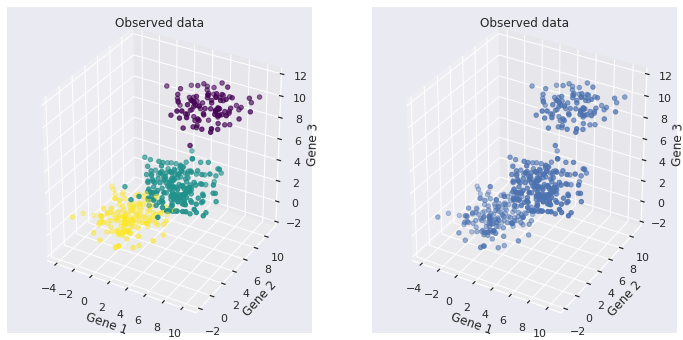

In [401]:
N=450
M=2
D=3
K=3

colors = [np.random.uniform(size=3) for k in range(K)]
vis_threshold = 0.05

sig = 3

mu = np.random.normal(0,3,size=(K,D))
mu[0]+=np.random.uniform(2*sig,3*sig, size=D)

sigma = [np.random.uniform(sig/2,sig,size=(D)) for k in range(K)]
for k in range(K):
    flat_dim = np.random.randint(D)
    sigma[k][k]=sigma[k][flat_dim]/5
cov = [np.diag(sigma[k]) for k in range(K)]

while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break
        
ind = np.ones(N)
x = np.zeros((N,D))

for n in range(N):
    opt = np.random.choice(list(range(K)), p=theta)
    ind[n] = opt
    newentry = np.random.multivariate_normal(mu[opt], cov[k])
    x[n,:] = newentry


    
sns.set()
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

## First level: PPCA

In [402]:
ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x}
fit = ppca_model.sampling(data=ppca_dat, iter=200, chains=1)
fitreturn = fit.extract()

best_ind = np.where(fitreturn['lp__']==max(fitreturn['lp__']))[0][0]

In [403]:
W_sim_ppca1 = np.mean(fitreturn['W'], axis=0)
sigma_sim_ppca1 = np.mean(fitreturn['sigma'], axis=0)
mu_sim_ppca1 = np.mean(fitreturn['mu'], axis=0)
latent_sim_ppca1 = fitreturn['z'][best_ind]

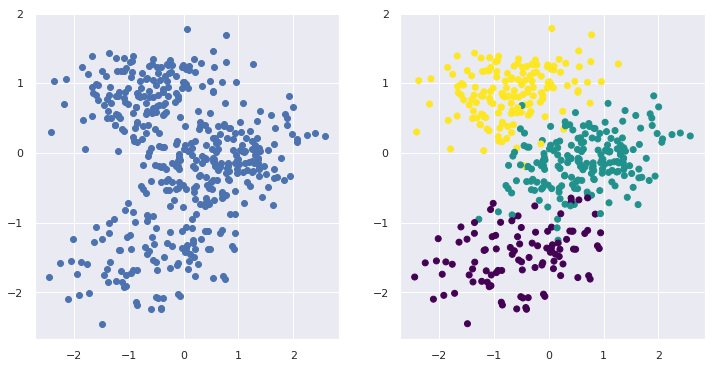

In [404]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:])
ax = fig.add_subplot(122)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:], c = ind, cmap='viridis')
plt.show()

## Second level: Mixture model on the latent space

### Automatic clusternumber determination
The GAP-statistic was proposed by Tibshirani, Walther and Hastie(2000), but it wasn't suitable for our data, so we're using the Akaike Information Criterion (AIC). We set a maximum of 2 sub-clusters, as we can always separate more clusters in the enxt layer, where the latent data will have a simpler form.

In [391]:
def GAP(points, k_max=2, nref=10):
    gap = []
    kmeans_list = []
    n,dims = np.shape(points)
    for K_clus in range(1,k_max+1):
        
        kmeans_init = KMeans(K_clus).fit(points)
        kmeans_list.append(kmeans_init)
        obs = np.log(kmeans_init.inertia_)
#         model = SpectralClustering(n_clusters=K_clus, affinity='nearest_neighbors',
#                            assign_labels='kmeans')
#         labels = model.fit_predict(points)
        
#         kmeans_list.append(labels)
        
        
#         centroids = [np.mean(points[labels==k],axis=0) for k in range(K_clus)]
#         print(K_clus,centroids)
#         mus = np.zeros((n,dims))
#         for k in range(K_clus):
#             mus[labels==k,:] = centroids[k]
#         sq_difs = np.sum(np.sqrt(np.sum((points-mus)**2,axis=0)))
#         obs = sq_difs
        exp = 0
        
#         for i in range(nref):
        tops = points.max(axis=0)
        bots = points.min(axis=0)
        dists = scipy.matrix(scipy.diag(tops-bots))
        rands = [scipy.random.random_sample(size=(n,dims)) for ref in range(nref)]
        for i in range(nref):
#             points_ref = np.array(rands[i]*dists+bots)
            points_ref = np.random.uniform(bots, tops, (n, dims))
            kmeans_ref = KMeans(K_clus).fit(points_ref)
            exp+=np.log(kmeans_ref.inertia_)
#             model_ref = SpectralClustering(n_clusters=K_clus, affinity='nearest_neighbors',
#                            assign_labels='kmeans')
#             labels_ref = model_ref.fit_predict(points_ref)
#             centroids_ref = [np.mean(points_ref[labels==k],axis=0) for k in range(K_clus)]
#             mus_ref = np.zeros((n,dims))
#             for k in range(K_clus):
#                 mus_ref[labels_ref==k,:] = centroids_ref[k]
#             sq_difs_ref = np.sum(np.sqrt(np.sum((points_ref-mus_ref)**2,axis=0)))
        
#             exp+= sq_difs_ref
            
        exp = exp/nref
#         exp2 = np.log((dims*n)/12)-(2/dims)*np.log(K_clus)
#         print(exp, exp2, exp-exp2, exp-obs, exp2-obs)
        gap.append(exp-obs)
        
    return list(range(1,k_max+1))[np.argmax(gap)], kmeans_list[np.argmax(gap)], gap

In [26]:
def est_k(points, k_max = 2, refs = 3, method='aic', verbose=False):
    clus = []
    aics = []
    bics = []
    mods = []
    for k in range(1,k_max+1):
        for ref in range(refs):
            model = KMeans(k).fit(points)
            mods.append(model)
            clus.append(k)
            a, b =kmeans_AIC(points,model, verbose=verbose)
            aics.append(a)
            bics.append(b)
    if clus[np.argmin(aics)]!=clus[np.argmin(bics)]:
        print(clus[np.argmin(aics)], ' clusters according to AIC, ', clus[np.argmin(bics)], ' clusters according to BIC.')
    if method=='aic':
        return clus[np.argmin(aics)], mods[np.argmin(aics)]
    elif method=='bic':
        return clus[np.argmin(bics)], mods[np.argmin(bics)]
    elif method=='both':
        return clus[np.argmin(aics)], mods[np.argmin(aics)], clus[np.argmin(bics)], mods[np.argmin(bics)]
    else:
        print("Choose 'aic' or 'bic' as method!")
        return 1
    
def kmeans_AIC(points, model, verbose=False):
    theta = np.array([sum(model.labels_==k) for k in range(model.n_clusters)])/np.shape(points)[0]
    probs = np.zeros((np.shape(points)[0],model.n_clusters))
    for k in range(model.n_clusters):
        probs[:,k] = multivariate_normal.logpdf(points, mean=model.cluster_centers_[k], cov=np.std(points[model.labels_==k].T)) 
    probs+=np.log(theta)
    llh = np.sum(logsumexp(probs,axis=1))
    
    aic = -2*llh + 2*np.shape(points)[1]*model.n_clusters
    bic = -2*llh + np.log(np.shape(points)[0])*np.shape(points)[1]*model.n_clusters
    if verbose:
        print('n_clusters: ',model.n_clusters, 'AIC: ',aic, 'BIC: ',bic)
    return aic, bic

To demonstrate that these estimates are accurate estimates:

In [20]:
N=1000
M=2
D=10
sig = 3
aic_ans = []
bic_ans = []
real_ans = []
for iteration in range(500):
    K=np.random.randint(1,11)

    mu = np.random.normal(0,3,size=(K,D))
    mu[0]+=np.random.uniform(2*sig,3*sig, size=D)

    sigma = [np.random.uniform(sig/2,sig,size=(D)) for k in range(K)]
    for k in range(K):
        flat_dim = np.random.randint(D)
        sigma[k][flat_dim]=sigma[k][flat_dim]/5
    cov = [np.diag(sigma[k]) for k in range(K)]

    while True:      # make sure to not have a negligible cluster
        theta = np.random.dirichlet(np.ones(K))
        if np.all(theta>(1.0/(2*K))):
            break
            
    x = np.zeros((N,D))

    for n in range(N):
        opt = np.random.choice(list(range(K)), p=theta)
        newentry = np.random.multivariate_normal(mu[opt], cov[k])
        x[n,:] = newentry
        
    K_inter_aic, _, K_inter_bic, _ = est_k(x, refs=2, k_max = 10, method='both')
    
    real_ans.append(K)
    aic_ans.append(K_inter_aic)
    bic_ans.append(K_inter_bic)
print('Rate of correct estimates (AIC): ', sum(np.array(real_ans)==np.array(aic_ans))/len(real_ans))
print('Rate of correct estimates (BIC): ', sum(np.array(real_ans)==np.array(bic_ans))/len(real_ans))
    

Rate of correct estimates (AIC):  0.966
Rate of correct estimates (BIC):  0.998


In [19]:
print('difference when guessed wrong (AIC): ',np.array(aic_ans)[np.array(real_ans)!=np.array(aic_ans)]-np.array(real_ans)[np.array(real_ans)!=np.array(aic_ans)])
print('difference when guessed wrong (BIC): ',np.array(bic_ans)[np.array(real_ans)!=np.array(bic_ans)]-np.array(real_ans)[np.array(real_ans)!=np.array(bic_ans)])

difference when guessed wrong (AIC):  [1 1 1 1 1 1 2 1 5 5 7 1 3 1 1 1 1]
difference when guessed wrong (BIC):  [1]


The AIC is a little more prone to overestimation, the BIC is more accurate.

### Selecting the separate clusters in the latent space

Since the latent data is not always enough to differentiate between two (or more) clusters, we'll use the full dataset straight away and feed the result to the MoPPCAs!

In [405]:
K_inter, clusters = est_k(x)
print('Estimated number of clusters: ', K_inter)

Estimated number of clusters:  2


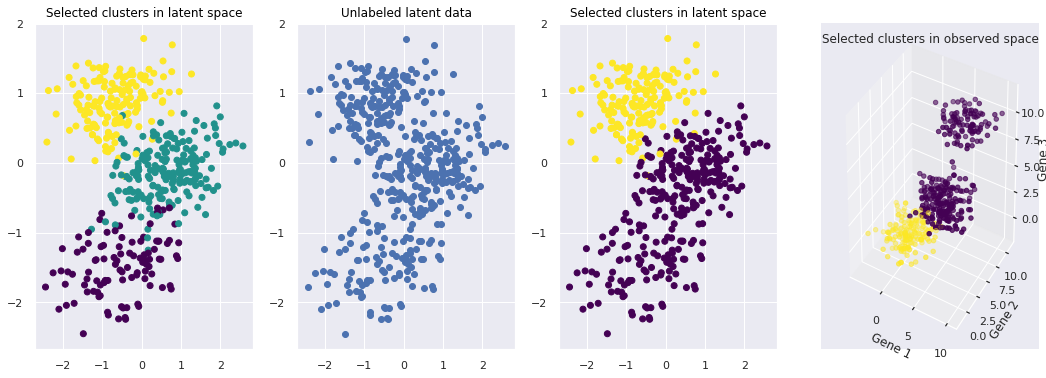

In [406]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,4,1)
ax.scatter(latent_sim_ppca1.T[:,0],latent_sim_ppca1.T[:,1], c=ind, cmap='viridis')
title = ax.set_title("Selected clusters in latent space")
plt.setp(title, color='black')
ax=fig.add_subplot(1,4,2)
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:])
title = ax.set_title("Unlabeled latent data")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,4,3)
ax.scatter(latent_sim_ppca1.T[:,0],latent_sim_ppca1.T[:,1], c=clusters.labels_, cmap='viridis')
title = ax.set_title("Selected clusters in latent space")
plt.setp(title, color='black')
ax = fig.add_subplot(144, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=clusters.labels_, cmap='viridis')
ax.set_title('Selected clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

### Initializing the latent variable mixture model based on selected clusters

In [407]:
clus_cent = clusters.cluster_centers_
gmm_dat = {'N': N,'M':M,'K': K_inter, 'D':D, 'y':x}
fit = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':clus_cent}])
fit_ext_molv1 = fit.extract()
best_ind_molv1 = np.where(fit_ext_molv1['lp__']==max(fit_ext_molv1['lp__']))[0][0]

latent_molv1 = fit_ext_molv1['z'][best_ind_molv1]
clus_norm_molv1 = np.mean(fit_ext_molv1['clusters'],axis=0).T
theta_molv1 = np.mean(fit_ext_molv1['theta'],axis=0)
mu_sim_molv1 = np.mean(fit_ext_molv1['mu'],axis=0)
sigmas_sim_molv1 = np.mean(fit_ext_molv1['sigma'],axis=0)

cats_full1 = np.argmax(clus_norm_molv1,axis=0)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


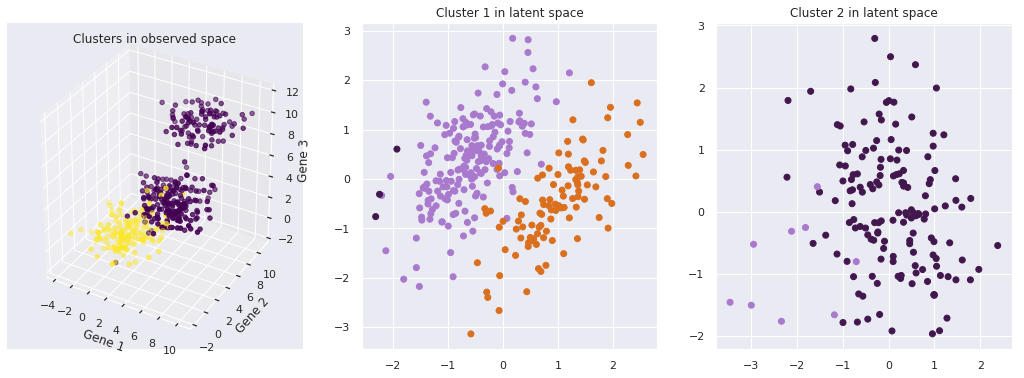

In [408]:
sns.set()
fig = plt.figure(figsize=((1+K_inter)*6,6))
ax=fig.add_subplot(1,1+K_inter,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=cats_full1, cmap='viridis')
ax.set_title('Clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
for k in range(K_inter):
    ax=fig.add_subplot(1,1+K_inter,k+2)
    rgba_colors=np.zeros((sum(clus_norm_molv1[k,:]>vis_threshold),4))
    for k_i in range(K):
        rgba_colors[ind[clus_norm_molv1[k,:]>vis_threshold]==k_i,:3] = colors[k_i]
    rgba_colors[:,3] = clus_norm_molv1[k,:][clus_norm_molv1[k,:]>vis_threshold]
    rgba_colors[:,1] = rgba_colors[:,1]/1.5
    ax.scatter(latent_molv1[k].T[:,0][clus_norm_molv1[k,:]>vis_threshold],latent_molv1[k].T[:,1][clus_norm_molv1[k,:]>vis_threshold], c=rgba_colors, cmap='viridis')
    ax.set_title('Cluster '+str(k+1)+' in latent space')
plt.show()

## Third level: Finding sub-clusters in the individual clusters

In [425]:
subclusters = [est_k(x[cats_full1==k]) for k in range(K_inter)]

In [428]:
subclusters

[(2, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
         n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
         random_state=None, tol=0.0001, verbose=0)),
 (1, KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
         n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
         random_state=None, tol=0.0001, verbose=0))]

### Latent variable mixture model based on selected sub-clusters

In [429]:
sec_layer_moppcas = []
for k in range(K_inter):
    gmm_dat = {'N': N,'M':M,'K': subclusters[k][0], 'D':D, 'y':x, 'weights':clus_norm_molv1[k,:]}
    fit = moppcas_weighted.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':subclusters[k][1].cluster_centers_}])
    fit_ext_molv2 = fit.extract()
    best_molv2 = np.where(fit_ext_molv2['lp__']==max(fit_ext_molv2['lp__']))[0][0]
    sec_layer_moppcas.append([fit_ext_molv2,best_molv2])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


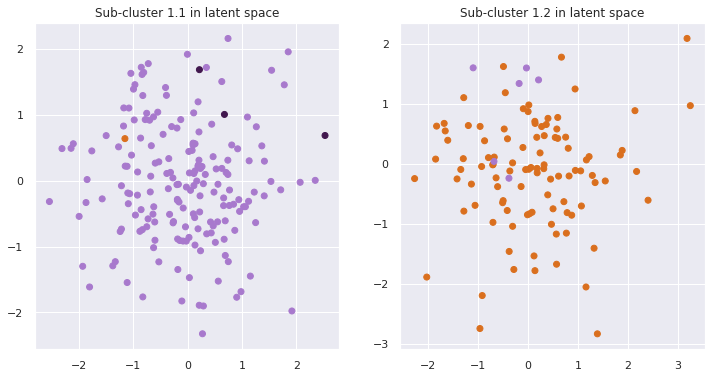

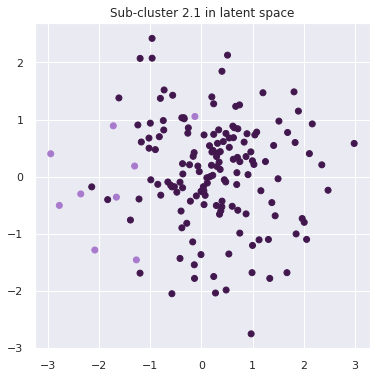

In [430]:
for clus in range(K_inter):
    fit_ext_molv2 = sec_layer_moppcas[clus][0]
    latent_molv2 = sec_layer_moppcas[clus][0]['z'][sec_layer_moppcas[clus][1]]
    latent_prenorm_molv2 = np.mean(fit_ext_molv2['clusters'],axis=0).T
    theta_sim_molv2 = np.mean(fit_ext_molv2['theta'],axis=0)
    mu_sim_molv2 = np.mean(fit_ext_molv2['mu'],axis=0)
    sigmas_sim_molv2 = np.mean(fit_ext_molv2['sigma'],axis=0)

    latent_norm_molv2 = latent_prenorm_molv2*clus_norm_molv1[clus,:][np.newaxis]
    total_probs = np.concatenate((clus_norm_molv1[0,:][np.newaxis].T,latent_norm_molv2.T),axis=1)
    cats_full2 = np.argmax(total_probs, axis=1)

    sns.set()
    K_last = subclusters[clus][0]
    fig = plt.figure(figsize=((K_last)*6,6))
    for k in range(K_last):
        ax=fig.add_subplot(1,K_last,k+1)
        rgba_colors=np.zeros((sum(latent_norm_molv2[k,:]>vis_threshold),4))
        for k_i in range(K):
            rgba_colors[ind[[latent_norm_molv2[k,:]>vis_threshold]]==k_i,:3] = colors[k_i]
        rgba_colors[:,3] = latent_norm_molv2[k,:][latent_norm_molv2[k,:]>vis_threshold]
        rgba_colors[:,1] = rgba_colors[:,1]/1.5
        ax.scatter(latent_molv2[k].T[:,0][latent_norm_molv2[k,:]>vis_threshold],latent_molv2[k].T[:,1][latent_norm_molv2[k,:]>vis_threshold], c=rgba_colors)
        ax.set_title('Sub-cluster '+str(clus+1)+'.'+str(k+1)+' in latent space')
    plt.show()

# Endresult of the hierarchical latent variable clustering model

In [431]:
all_latent = np.concatenate((latent_molv1[0][np.newaxis], latent_molv2),axis=0)

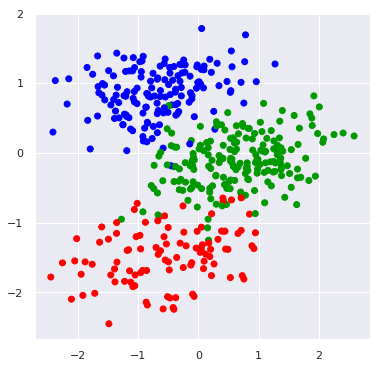

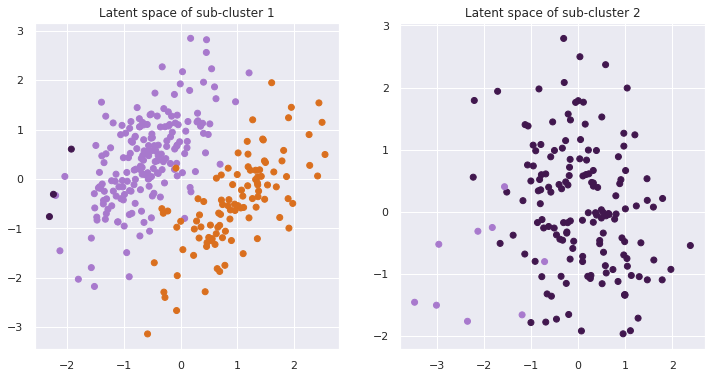

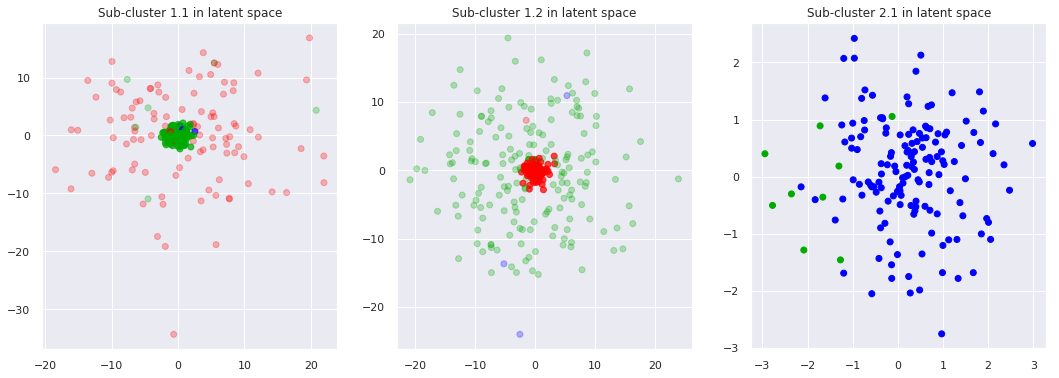

In [432]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
rgba_colors = np.zeros((N,4))
for k_i in range(K):
    rgba_colors[ind==k_i,k_i] = 1.0
rgba_colors[:,3] = 1.0
rgba_colors[:,1] = 0.6*rgba_colors[:,1]
ax.scatter(latent_sim_ppca1[0,:],latent_sim_ppca1[1,:], c=rgba_colors)
plt.show()

fig = plt.figure(figsize=(K_inter*6, 6))
for k in range(K_inter):
    ax = fig.add_subplot(1,K_inter,k+1)
    rgba_colors=np.zeros((sum(clus_norm_molv1[k,:]>0.01),4))
    for k_i in range(K):
        rgba_colors[ind[clus_norm_molv1[k,:]>vis_threshold]==k_i,:3] = colors[k_i]
    rgba_colors[:,3] = clus_norm_molv1[k,:][clus_norm_molv1[k,:]>vis_threshold]
    rgba_colors[:,1] = rgba_colors[:,1]/1.5
    ax.scatter(latent_molv1[k].T[:,0][clus_norm_molv1[k,:]>vis_threshold],latent_molv1[k].T[:,1][clus_norm_molv1[k,:]>vis_threshold], c=rgba_colors, cmap='viridis')
    ax.set_title('Latent space of sub-cluster '+str(k+1))
plt.show()

K_sub = sum([k[0] for k in subclusters])
fig = plt.figure(figsize=(K_sub*6, 6))
count = 1
norms = []
for clus in range(K_inter):
    K_last = subclusters[clus][0]
    fit_ext_molv2 = sec_layer_moppcas[clus][0]
    latent_molv2 = sec_layer_moppcas[clus][0]['z'][sec_layer_moppcas[clus][1]]
    clus_molv2 = np.mean(fit_ext_molv2['clusters'],axis=0)
    latent_prenorm_molv2 = np.exp(clus_molv2)/np.sum(np.exp(clus_molv2),axis=1)[np.newaxis].T
    latent_norm_molv2 = latent_prenorm_molv2*clus_norm_molv1[clus,:][np.newaxis].T
    norms.append(latent_norm_molv2.copy())
    for k in range(K_last):
            ax=fig.add_subplot(1,K_sub,count)
            
            rgba_colors=np.zeros((sum(latent_norm_molv2[:,k]>vis_threshold),4))
            for k_i in range(K):
                rgba_colors[ind[latent_norm_molv2[:,k]>vis_threshold]==k_i,k_i] = 1.0
            rgba_colors[:,3] = latent_norm_molv2[:,k][latent_norm_molv2[:,k]>0.01]
            rgba_colors[:,1] = rgba_colors[:,1]/1.5
            ax.scatter(latent_molv2[k].T[:,0][latent_norm_molv2[:,k]>vis_threshold],latent_molv2[k].T[:,1][latent_norm_molv2[:,k]>vis_threshold], c=rgba_colors, cmap='viridis')
            ax.set_title('Sub-cluster '+str(clus+1)+'.'+str(k+1)+' in latent space')
            count+=1
total_norms = np.concatenate(norms, axis=1)
final_subclusters = np.argmax(total_norms,axis=1)

As suggested in the original article, the density of the ink in each dot represents the posterior probability of the datapoint belonging in the sub-cluster. The colours represent the true cluster in all plots.

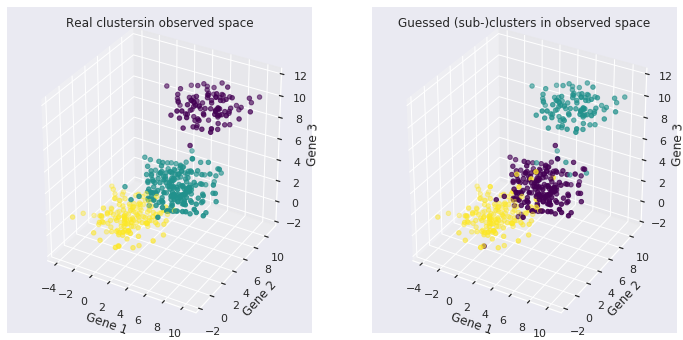

In [433]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Real clustersin observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax=fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=final_subclusters, cmap='viridis')
ax.set_title('Guessed (sub-)clusters in observed space')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

# Summarized algorithm

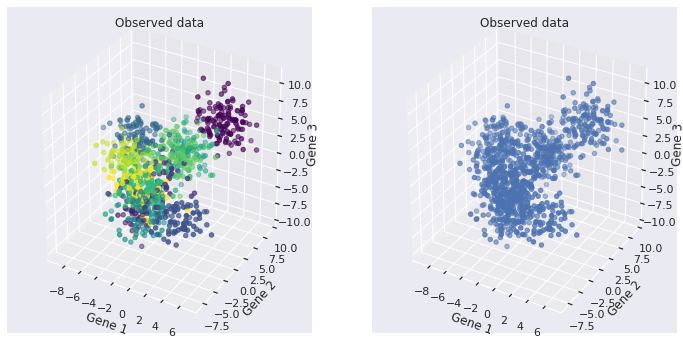

In [14]:
N=1000
M=2
D=10
K=13

colors = [np.random.uniform(size=3) for k in range(K)]
vis_threshold = 0.05

sig = 3

mu = np.random.normal(0,3,size=(K,D))
mu[0]+=np.random.uniform(2*sig,3*sig, size=D)

sigma = [np.random.uniform(sig/2,sig,size=(D)) for k in range(K)]
for k in range(K):
    flat_dim = np.random.randint(D)
    sigma[k][flat_dim]=sigma[k][flat_dim]/5
cov = [np.diag(sigma[k]) for k in range(K)]

while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break
        
ind = np.ones(N)
x = np.zeros((N,D))

for n in range(N):
    opt = np.random.choice(list(range(K)), p=theta)
    ind[n] = opt
    newentry = np.random.multivariate_normal(mu[opt], cov[k])
    x[n,:] = newentry


    
sns.set()
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], cmap='viridis')
# ax.scatter(mu[:,0], mu[:,1], mu[:,2])
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

This is a fully automated algorithm that runs every step for as many levels as defined, unless all subclusters appear to be unsuited for further separation. It has been added to 'utils.py'.

In [438]:
class hierarchical_model:
    
    def __init__(self):
        
        self.probs = [np.ones(N)[np.newaxis].T]
        self.latent = [[]]
        self.mus = [[]]
        self.cats_per_lvl = []
        self.colors = [np.random.uniform(size=3) for k in range(k_max**max_depth)]
    
    def fit(self,x, M=2, max_depth=5, k_max = 2, plotting=True, min_clus_size=10):
        
        # initialize the algorithm
        self.M = M
        if M>3 and plotting:
            print('Latent dimensions greater than 3, plotting only the three most important dimensions.')
        moppcas_weighted = loadStan('moppcas_weighted')
        ppca_weighted = loadStan('ppca_weighted')

        N,D = np.shape(x)
        self.N = N

        # top-level latent data
        print('Latent data on top level:')
        ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x, 'weights': self.probs[-1][:,0]}
        fit_top = ppca_weighted.sampling(data=ppca_dat, iter=200, chains=1)
        fitreturn_top = fit_top.extract()
        best_ind_top = np.where(fitreturn_top['lp__']==max(fitreturn_top['lp__']))[0][0]
        latent_top = fitreturn_top['z'][best_ind_top]
        self.latent[-1].append(latent_top)

        # top-level cluster determination
        K_1, clusters_1 = est_k(x)
        self.mus[-1].append(clusters_1.cluster_centers_)
        print('Estimated number of clusters (level 0): ', K_1)
        
        # in case M>3, find out which three dimensions to plot in 3D
        if M>2:
            chosen = []
            for dim in range(3):
                s = 0
                for i in range(self.M):
                    if i not in chosen:
                        if np.std(self.latent[0][0][i,:])>s:
                            s = np.std(self.latent[0][0][i,:])
                            best = i
                chosen.append(best)
            self.dimx,self.dimy,self.dimz = chosen
        
        # plot top-level latent data with coloured first clusters
        if plotting:
            rgba_colors = np.zeros((N,4))
#             for k_i in range(K_1):
            rgba_colors[:,:3] = self.colors[0]
            rgba_colors[:,3] = 1.0
            fig = plt.figure(figsize=(6,6))
            if M==2:
                ax = fig.add_subplot(111)
                plt.scatter(self.latent[-1][0][0,:],self.latent[-1][0][1,:], c = rgba_colors)
            if M>2:
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(self.latent[-1][0][self.dimx,:],self.latent[-1][0][self.dimy,:],self.latent[-1][0][self.dimz,:], c = rgba_colors)
            ax.set_title('Top-level latent data')
            plt.show()

        cats = np.argmax(self.probs[-1],axis=1)
        self.cats_per_lvl.append(cats.copy())

        for lvl in range(max_depth):
            # repeat cluster detemination and MoPPCAs until max_depth is reached or until all clusters fully analyzed
            more_depth = False
            print('level ', lvl+1, ':')
            cur_probs = self.probs[-1].copy()
            # probability matrix of clusters is sometimes transposed
            if np.shape(cur_probs)[1]==N:
                cur_probs = cur_probs.T
            n_clus = np.shape(cur_probs)[1]
            count = 0
            self.latent.append([])
            
            # analyze all subclusters as found in the last level
            for cl in range(n_clus):
                # Dont divide clusters further if they are too small
                if sum(cats==cl)>k_max:
                    n_subs, subs = est_k(x[cats==cl], k_max = k_max)
                    while np.any([sum(subs.labels_==k_i)<min_clus_size for k_i in range(n_subs)]):
                        if n_subs <= 2:
                            n_subs = 1
                            break
                        n_subs, subs = est_k(x[cats==cl], k_max = n_subs-1)
                else:
                    n_subs = 1
                clus_probs = cur_probs[:,cl]
                if n_subs == 1:
                    # If cluster doesnt contain more subclusters, just copy it over to the next level
                    print('Cluster ', cl+1, ' doesnt contain any more subclusters')
                    new_probs = clus_probs[np.newaxis].T
                    cur_latent = self.latent[-2][cl]
                    self.latent[-1].append(cur_latent)
                    mask = clus_probs>vis_threshold
                    # And plot if chosen so
                    if plotting:
                        rgba_colors = np.zeros((sum(mask),4))
                        rgba_colors[:,:3] = self.colors[count]
                        rgba_colors[:,3] = new_probs[mask,0]
                        fig = plt.figure(figsize=(6,6))
                        if M==2:
                            ax = fig.add_subplot(111)
                            ax.scatter(cur_latent[0,mask], cur_latent[1,mask], c=rgba_colors)
                        if M>2:
                            ax = fig.add_subplot(111, projection='3d')
                            ax.scatter(cur_latent[self.dimx,mask], cur_latent[self.dimy,mask], cur_latent[self.dimz,mask], c=rgba_colors)
                        ax.set_title('Latent data of subcluster '+str(cl+1)+' (copied over from higher level)')
                        plt.show()
                    count+=1
                else:
                    # If cluster contains more subclusters, initiate MoPPCAs
                    more_depth = True
                    print('Cluster ', cl+1, ' contains ',n_subs,' subclusters')
                    moppcas_dat = {'N':N, 'M':M,'K':n_subs, 'D':D, 'y':x, 'weights':clus_probs}
                    fit = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=100, init=[{'mu':subs.cluster_centers_}])
                    fit_ext_molv1 = fit.extract()
                    best_molv1 = np.where(fit_ext_molv1['lp__']==max(fit_ext_molv1['lp__']))[0][0]
                    cur_latent = fit_ext_molv1['z'][best_molv1]
                    new_probs = (np.mean(fit_ext_molv1['clusters'],axis=0).T*clus_probs).T
                    plotcats = np.argmax(new_probs, axis=1)
                    
                    # and plot latent data of all newfound subclusters if chosen so
                    for i,l in enumerate(cur_latent):
                        plotprobs = new_probs[:,i]
                        mask = plotprobs>vis_threshold
                        self.latent[-1].append(l)
                        if plotting:
                            rgba_colors = np.zeros((sum(mask),4))
#                             n_subs, subs = est_k(x[mask], k_max = k_max)
#                             for k_i in range(n_subs):
                            rgba_colors[:,:3] = self.colors[count]
                            count+=1
                            rgba_colors[:,3] = plotprobs[mask]
                            fig = plt.figure(figsize=(6,6))
                            if M==2:
                                ax = fig.add_subplot(111)
                                ax.scatter(l[0,mask],l[1,mask], c=rgba_colors)
                            if M>2:
                                ax = fig.add_subplot(111, projection='3d')
                                ax.scatter(l[self.dimx,mask],l[self.dimy,mask], l[self.dimz,mask], c=rgba_colors)
                            ax.set_title('Latent data of subcluster '+str(i+1))
                            plt.show()
                if cl==0:
                    probs_round = new_probs
                else:
                    probs_round = np.hstack((probs_round, new_probs))

            cats = np.argmax(probs_round,axis=1)
            
            # Plotting Top-level latent data with new cluster-colouring
            fig = plt.figure(figsize=(6,6))
            if M==2:
                ax = fig.add_subplot(111)
            if M>2:
                ax = fig.add_subplot(111, projection='3d')
            for c in range(np.shape(probs_round)[1]):
                mask = probs_round[:,c]>vis_threshold
                rgba_colors = np.zeros((sum(mask),4))
                rgba_colors[:,:3] = self.colors[c]
                rgba_colors[:,3] = probs_round[:,c][mask]
                if M==2:
                    ax.scatter(self.latent[0][0][0,mask],self.latent[0][0][1,mask], c = rgba_colors)
                if M>2:
                    ax.scatter(self.latent[0][0][self.dimx,mask],self.latent[0][0][self.dimy,mask],self.latent[0][0][self.dimz,mask], c = rgba_colors)
            ax.set_title('Clusters after level '+str(lvl+1))
            plt.show()

            # Stop if all clusters are fully analyzed
            if more_depth == False:
                print('All clusters are fully analyzed!')
                self.latent = self.latent[:-1]
                return self.latent[-1], self.cats_per_lvl[-1], self.probs[-1]
            
            self.probs.append(probs_round.copy())
            self.cats_per_lvl.append(cats.copy())
            
        return self.latent[-1], self.cats_per_lvl[-1], self.probs[-1]
    
    def visualize_tree(self,categories = None, vis_threshold=0.05):
        # plot the subdivision of clusters in hierarchical order
        if np.all(categories)==None:
            categories = self.cats_per_lvl[-1]
        for lvl in range(len(self.latent)):
            print('Level ', lvl)
            n_lat = len(self.latent[lvl])
            fig = plt.figure(figsize=(min(n_lat*6, 24), (int((n_lat-1)/4)+1)*6))
            for lat in range(n_lat):
                rgba_colors = np.zeros((self.N, 4))
                for k_i in range(int(max(categories))):
                    rgba_colors[categories==k_i,:3] = self.colors[k_i]
                if np.shape(self.probs[lvl])[0]==N:
                    n_cat = np.shape(self.probs[lvl])[1]
                    prob_cur = self.probs[lvl]
                else:
                    n_cat = np.shape(self.probs[lvl])[0]
                    prob_cur = self.probs[lvl].T
                for k_i in range(n_cat):
                    rgba_colors[:,3] = prob_cur[:,lat]
                vis_mask = np.array(prob_cur[:,lat]>vis_threshold)
                if M==2:
                    ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat+1)
                    ax.scatter(self.latent[lvl][lat][0,vis_mask],self.latent[lvl][lat][1,vis_mask],c = rgba_colors[vis_mask,:])
                if M>2:
                    ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat, projection='3d')
                    ax.scatter(self.latent[lvl][lat][self.dimx,vis_mask],self.latent[lvl][lat][self.dimy,vis_mask],self.latent[lvl][lat][self.dimz,vis_mask],c = rgba_colors[vis_mask,:])
            plt.suptitle('Clusters on level '+str(lvl))
            plt.show()
        return
            
    def visualize_end(self,categories = None):
        # plot the top-level latent data with the end-result of the clustering as colouring
        if np.all(categories)==None:
            categories = self.cats_per_lvl[-1]
            title = 'Top-level latent data coloured by guessed clusters'
        else:
            title = 'Top-level latent data coloured by given clusters'
        rgba_colors = np.ones((N, 4))
        for k_i in range(int(max(categories))):
            rgba_colors[categories==k_i,:3] = self.colors[k_i]
#             rgba_colors[categories==k_i,3] = self.probs[-1][categories==k_i,k_i]
        fig = plt.figure(figsize=(6,6))
        if self.M==2:
#             print('Plotting 2-dimensional latent data with final cluster colouring.')
            ax = fig.add_subplot(111)
            ax.scatter(self.latent[0][0][0,:],self.latent[0][0][1,:],c = rgba_colors)
        if self.M>2:
#             print('Plotting 3-dimensional latent data with final cluster colouring.')
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(self.latent[0][0][self.dimx,:],self.latent[0][0][self.dimy,:],self.latent[0][0][self.dimz,:],c = rgba_colors)
        ax.set_title(title)
        plt.show()
        return
    
    def visualize_latent_final(self, categories=None):
        # plot the latent spaces of all found subclusters
        if np.all(categories)==None:
            title = 'Latent data coloured by guessed clusters'
            categories = self.cats_per_lvl[-1]
        else:
            title = 'Latent data coloured by given clusters'
        n_lat = len(self.latent[-1])
        fig = plt.figure(figsize=(min(n_lat*6, 24), (int((n_lat-1)/4)+1)*6))
        for lat in range(n_lat):
            rgba_colors = np.zeros((self.N, 4))
            for k_i in range(int(max(categories))):
                rgba_colors[categories==k_i,:3] = self.colors[k_i]
            if np.shape(self.probs[-1])[0]==N:
                n_cat = np.shape(self.probs[-1])[1]
                prob_cur = self.probs[-1]
            else:
                n_cat = np.shape(self.probs[-1])[0]
                prob_cur = self.probs[-1].T
            for k_i in range(n_cat):
                rgba_colors[:,3] = prob_cur[:,lat]
            vis_mask = np.array(prob_cur[:,lat]>vis_threshold)
            if M==2:
                ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat+1)
                ax.scatter(self.latent[-1][lat][0,vis_mask],self.latent[-1][lat][1,vis_mask],c = rgba_colors[vis_mask,:])
            if M>2:
                ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat, projection='3d')
                ax.scatter(self.latent[-1][lat][self.dimx,vis_mask],self.latent[-1][lat][self.dimy,vis_mask],self.latent[-1][lat][self.dimz,vis_mask],c = rgba_colors[vis_mask,:])
        plt.suptitle(title)
        plt.show()
        return

In [439]:
model = hierarchical_model()

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Estimated number of clusters (level 0):  2


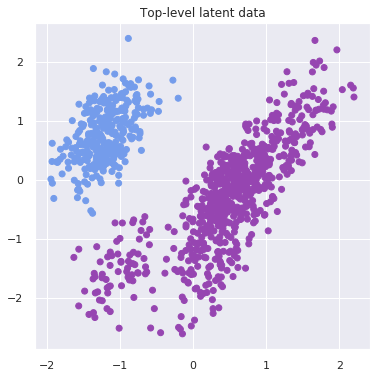

level  1 :
Cluster  1  contains  2  subclusters


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


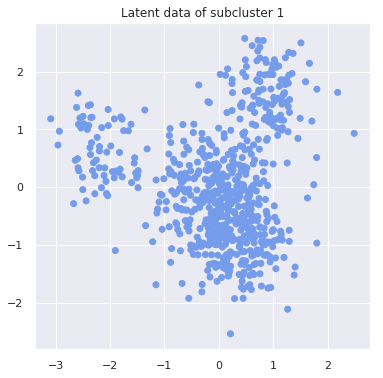

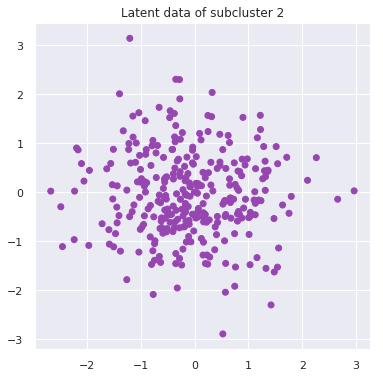

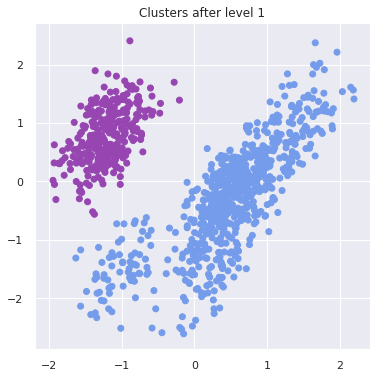

level  2 :
Cluster  1  contains  2  subclusters


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


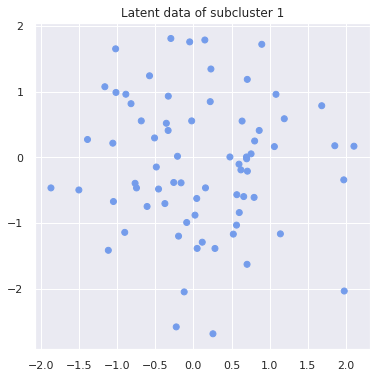

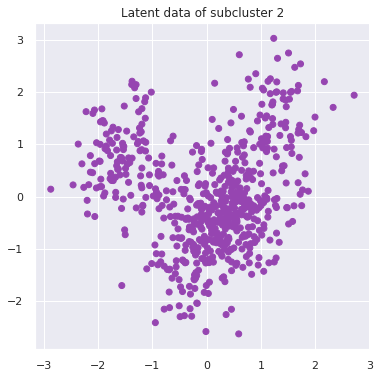

Cluster  2  doesnt contain any more subclusters


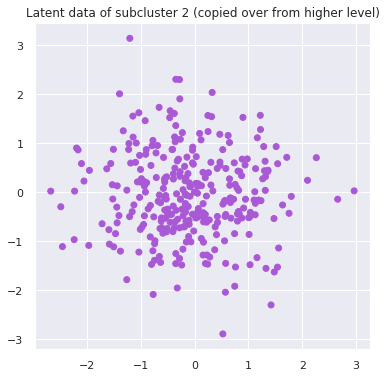

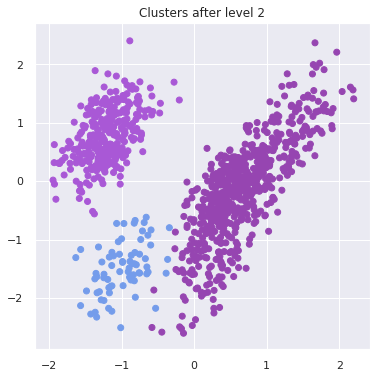

level  3 :
Cluster  1  doesnt contain any more subclusters


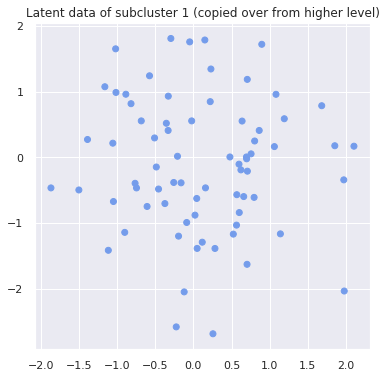

Cluster  2  contains  2  subclusters


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


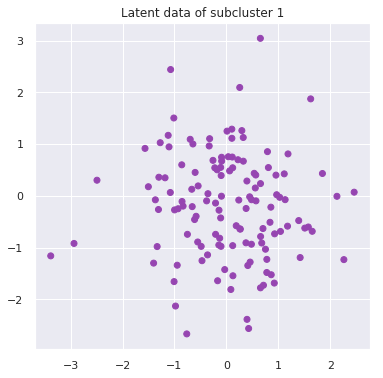

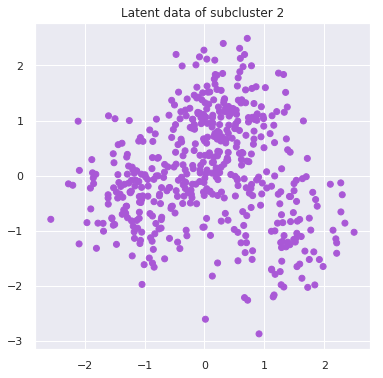

Cluster  3  doesnt contain any more subclusters


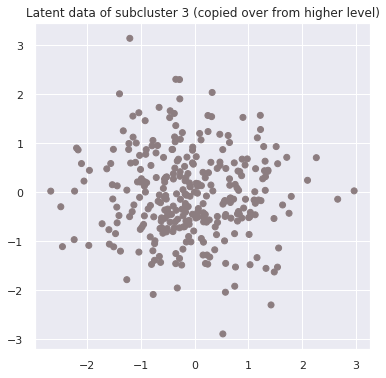

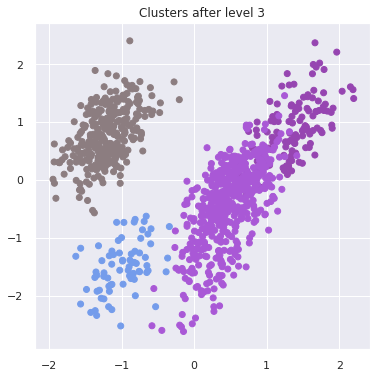

level  4 :
Cluster  1  doesnt contain any more subclusters


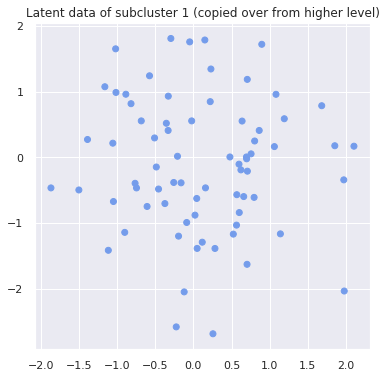

Cluster  2  doesnt contain any more subclusters


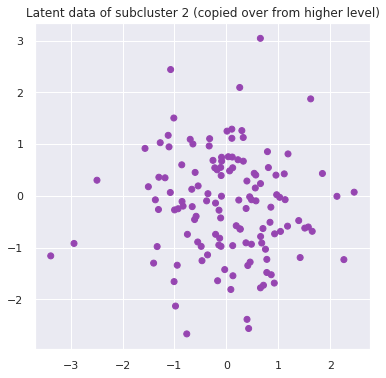

Cluster  3  contains  2  subclusters


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


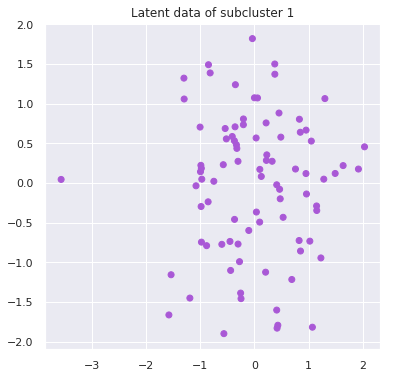

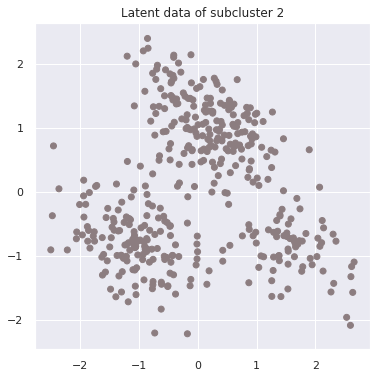

Cluster  4  doesnt contain any more subclusters


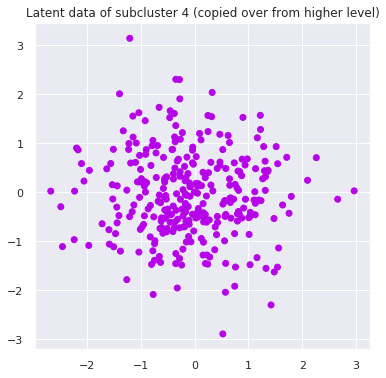

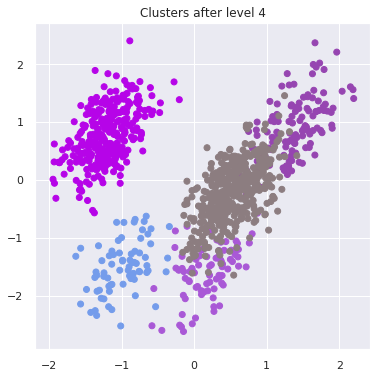

level  5 :
Cluster  1  doesnt contain any more subclusters


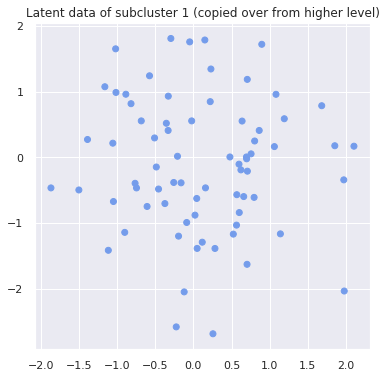

Cluster  2  doesnt contain any more subclusters


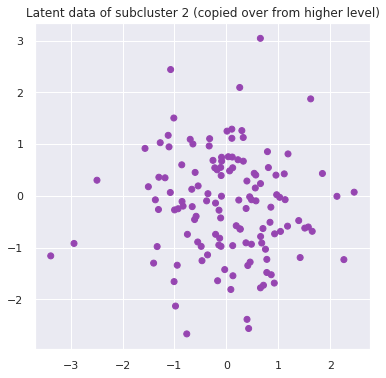

Cluster  3  doesnt contain any more subclusters


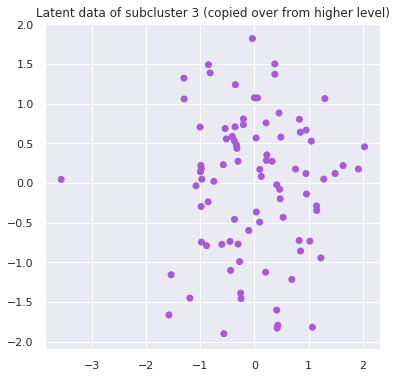

Cluster  4  contains  2  subclusters


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


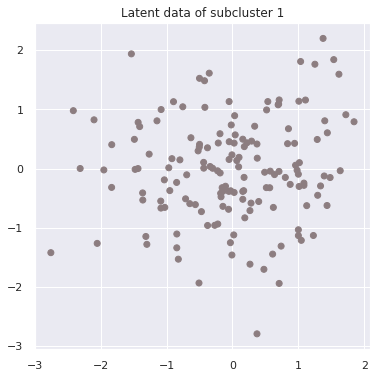

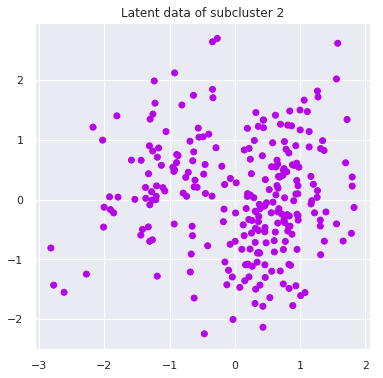

Cluster  5  doesnt contain any more subclusters


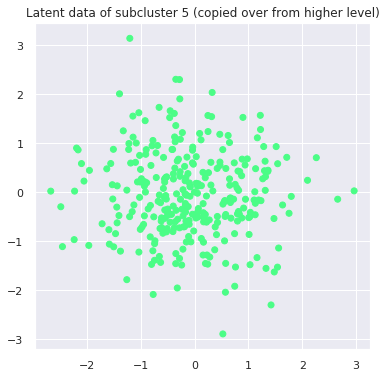

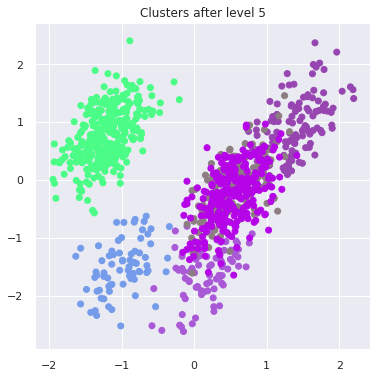

In [440]:
latent, cats, probs = model.fit(x)

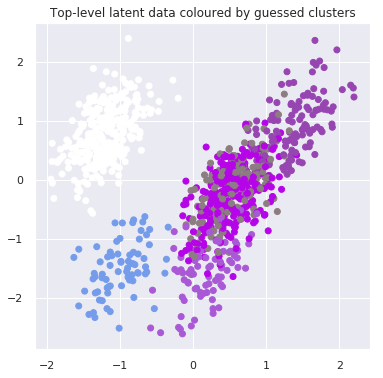

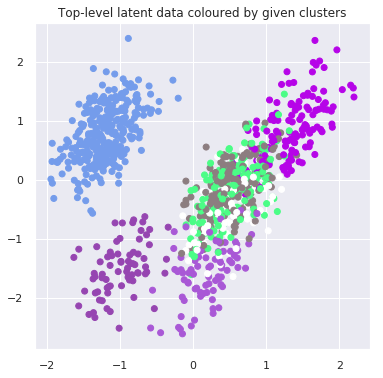

In [441]:
model.visualize_end()
model.visualize_end(categories=ind)

Latent data coloured by guessed clusters:
Level  0


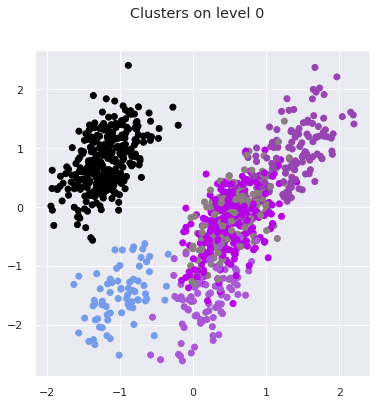

Level  1


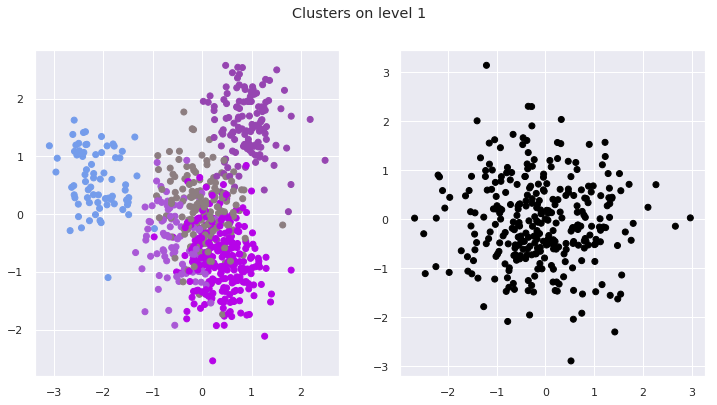

Level  2


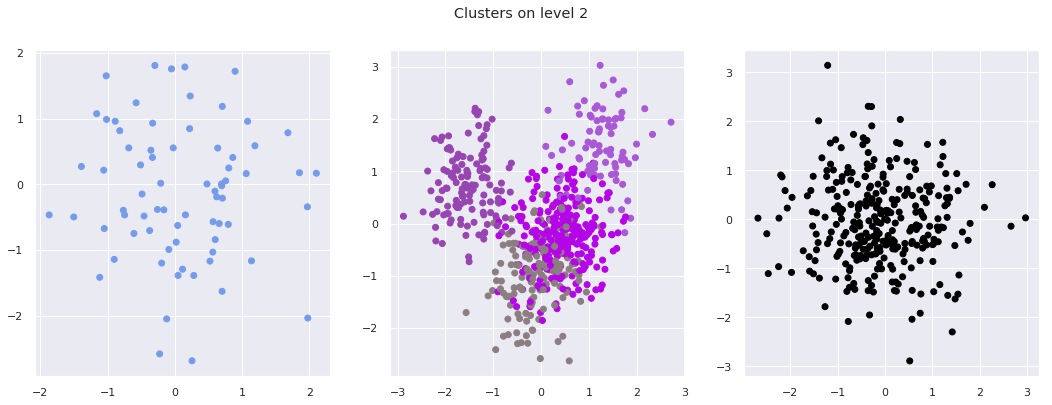

Level  3


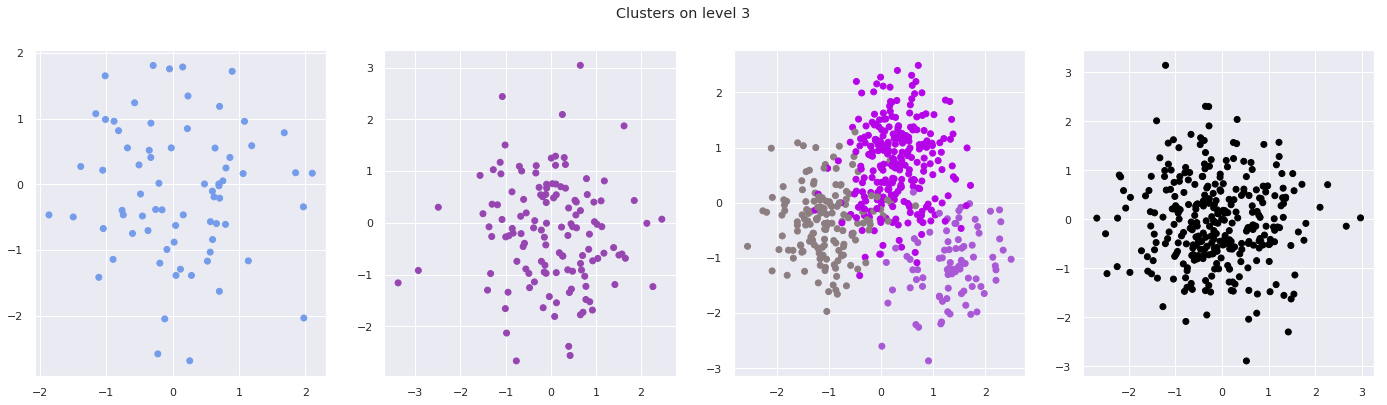

Level  4


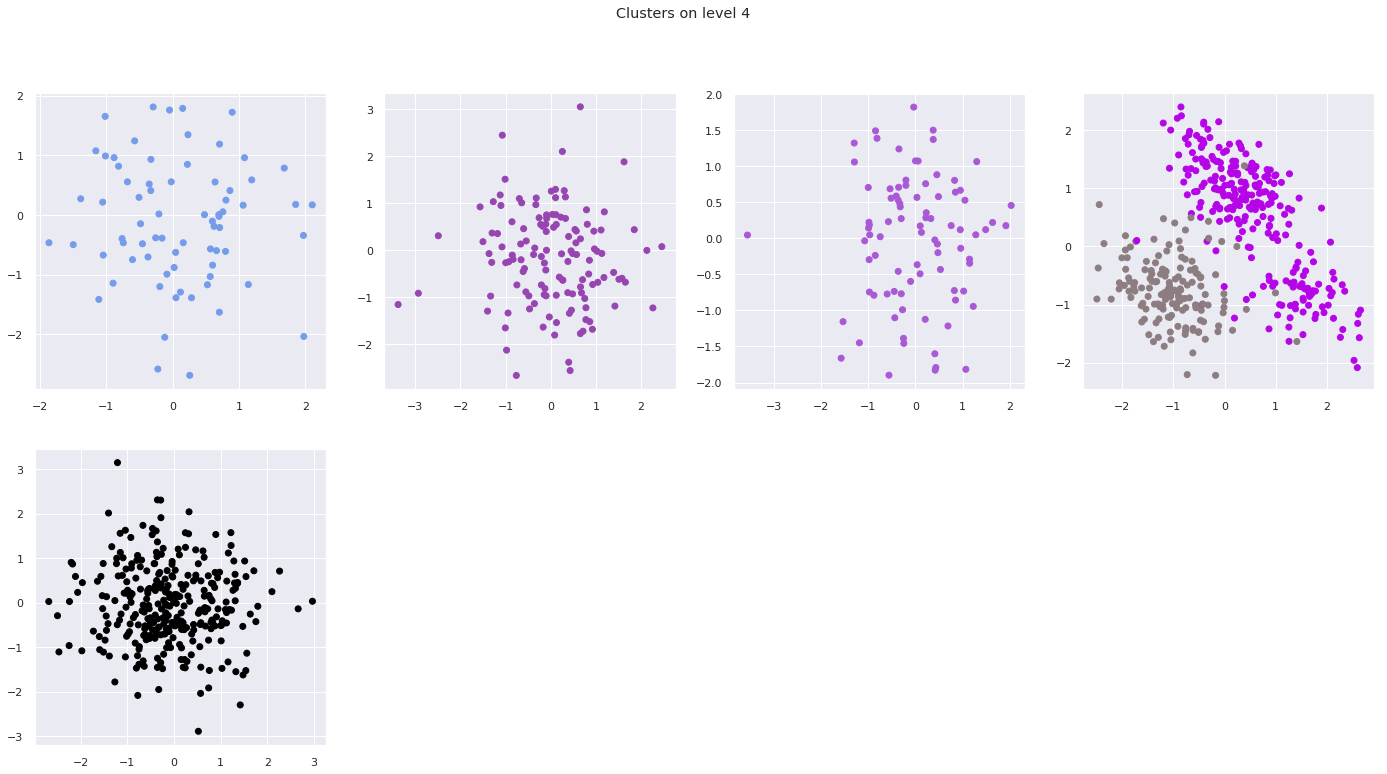

Level  5


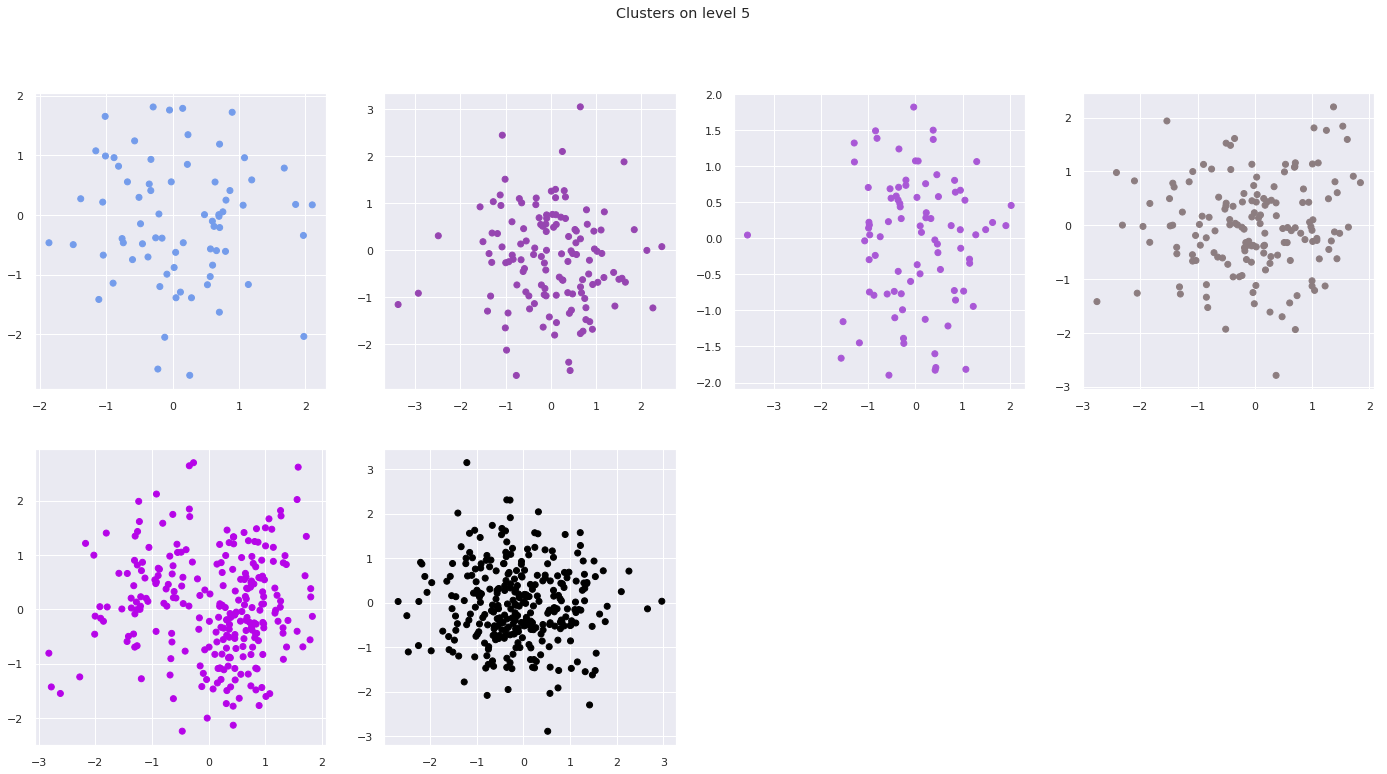

In [442]:
print('Latent data coloured by guessed clusters:')
model.visualize_tree()

Latent data coloured by true clusters:


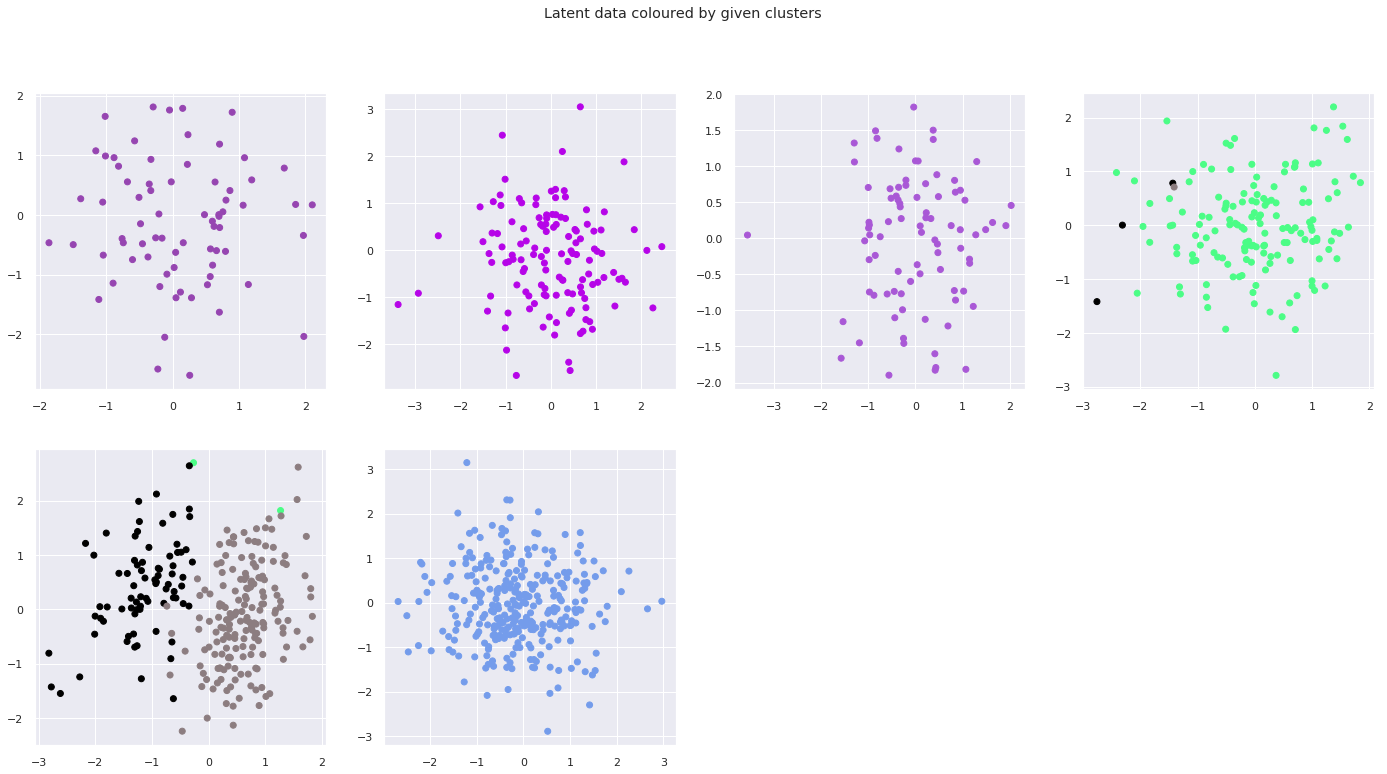

In [443]:
print('Latent data coloured by true clusters:')
model.visualize_latent_final(categories=ind)

In [444]:
adjusted_rand_score(ind, cats)

0.9014980604320534

Nice!